In [1]:
!pip install tldextract tensorflow scikit-learn pandas numpy matplotlib


In [2]:
%cd /content/drive/MyDrive/PhishGuard/model

!ls


/content/drive/MyDrive/PhishGuard/model
phishing_urls.csv  __pycache__	utils.py


In [3]:
import pandas as pd
import numpy as np
from utils import Preprocessor
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [4]:
df = pd.read_csv('/content/drive/MyDrive/PhishGuard/model/phishing_urls.csv')
df.head()


,url,label
0,https://blockchaoin.info/#/,bad
1,https://www.insects.org/ced4/crush_freaks.html,good
2,https://www.elpasotimes.com/story/opinion/edit...,good
3,http://direct-certs.bankofamerica.com.techdbas...,bad
4,https://gotham-magazine.com/lalique-unveils-ep...,good


In [5]:
# Drop duplicates and missing entries
df = df.dropna().drop_duplicates().reset_index(drop=True)
df['url'] = df['url'].astype(str).str.lower()

# Encode the labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
print("Label classes:", le.classes_)
df['label'].value_counts()


Label classes: ['bad' 'good']


,count
label,
1,864585
0,693647


In [6]:
preprocessor = Preprocessor()
X = preprocessor.fit_transform(df)
y = df['label'].values

print("Feature matrix shape:", X.shape)


Tokenizing the URLs...
Extracting features...
Concatenating all features...
Tokenizing the URLs...
Extracting features...
Concatenating all features...
Feature matrix shape: (1558232, 109)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle imbalance
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.1232175262246427), 1: np.float64(0.9011440459873812)}


In [8]:
input_dim = X_train.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.15,
    epochs=25,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=2
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
33113/33113 - 107s - 3ms/step - accuracy: 0.8617 - loss: 0.3120 - val_accuracy: 0.8769 - val_loss: 0.2744
Epoch 2/25
33113/33113 - 112s - 3ms/step - accuracy: 0.8734 - loss: 0.2880 - val_accuracy: 0.8817 - val_loss: 0.2632
Epoch 3/25
33113/33113 - 108s - 3ms/step - accuracy: 0.8758 - loss: 0.2827 - val_accuracy: 0.8828 - val_loss: 0.2616
Epoch 4/25
33113/33113 - 109s - 3ms/step - accuracy: 0.8767 - loss: 0.2799 - val_accuracy: 0.8825 - val_loss: 0.2618
Epoch 5/25
33113/33113 - 106s - 3ms/step - accuracy: 0.8776 - loss: 0.2774 - val_accuracy: 0.8841 - val_loss: 0.2582
Epoch 6/25
33113/33113 - 104s - 3ms/step - accuracy: 0.8785 - loss: 0.2766 - val_accuracy: 0.8847 - val_loss: 0.2571
Epoch 7/25
33113/33113 - 103s - 3ms/step - accuracy: 0.8787 - loss: 0.2756 - val_accuracy: 0.8854 - val_loss: 0.2569
Epoch 8/25
33113/33113 - 114s - 3ms/step - accuracy: 0.8792 - loss: 0.2749 - val_accuracy: 0.8841 - val_loss: 0.2578
Epoch 9/25
33113/33113 - 104s - 3ms/step - accuracy: 0.8795 - lo

In [9]:
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))


9739/9739 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
              precision    recall  f1-score   support

           0       0.83      0.93      0.88    138730
           1       0.94      0.85      0.89    172917

    accuracy                           0.89    311647
   macro avg       0.89      0.89      0.89    311647
weighted avg       0.89      0.89      0.89    311647

Confusion Matrix:
 [[129321   9409]
 [ 25745 147172]]
ROC AUC: 0.959315469221778


In [10]:
# Save model to Drive
model.save('/content/drive/MyDrive/PhishGuard/model/phishguard.h5')

# Save preprocessor
with open('/content/drive/MyDrive/PhishGuard/model/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Save label encoder too
with open('/content/drive/MyDrive/PhishGuard/model/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model and preprocessor saved to Drive.")


Model and preprocessor saved to Drive.


In [11]:
from tensorflow.keras.models import load_model
import pandas as pd
import pickle

# Load saved artifacts
model = load_model('/content/drive/MyDrive/PhishGuard/model/phishguard.h5')
with open('/content/drive/MyDrive/PhishGuard/model/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

test_url = "https://secure-login.paypal-update.com"
df_test = pd.DataFrame([[test_url, None]], columns=['url', 'label'])
X_test_url = preprocessor.transform(df_test)
pred_prob = model.predict(X_test_url)[0][0]
label = "Phishing" if pred_prob < 0.5 else "Legitimate"
print(f"URL: {test_url}\nPredicted: {label} (prob={pred_prob:.3f})")


Tokenizing the URLs...
Extracting features...
Concatenating all features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
URL: https://secure-login.paypal-update.com
Predicted: Legitimate (prob=0.947)


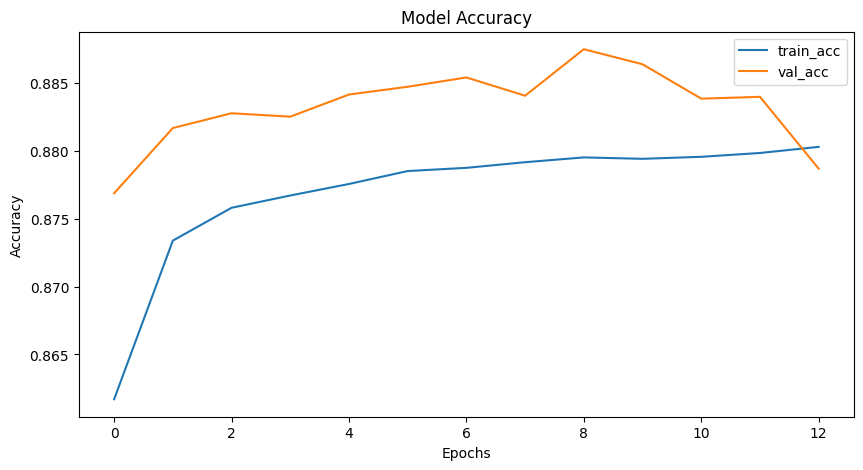

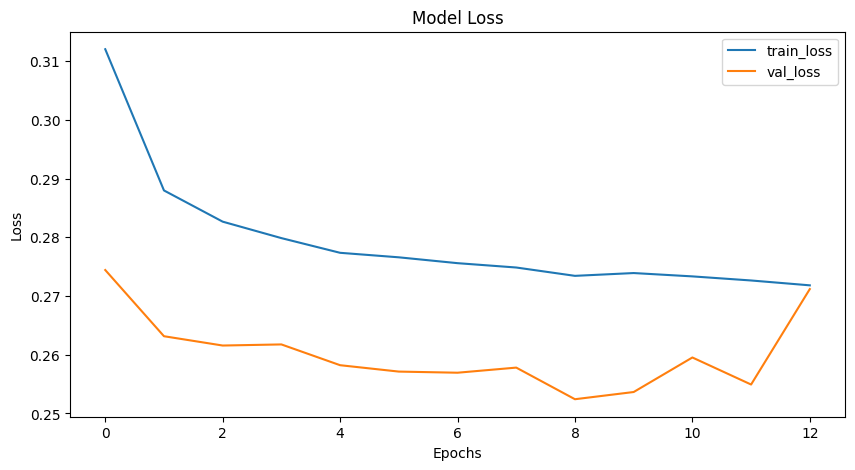

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
